In [21]:
from dsc80_utils import *
import lec16_util as util

# Lecture 16 – Hyperparameters, Cross-Validation, and Decision Trees


## Review: Pipelines

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, Binarizer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression

tips = px.data.tips()

In [23]:
def is_weekend(s):
    # The input to is_weekend is a Series!
    return s.replace({'Thur': 'Weekday', 'Fri': 'Weekday'})

In [24]:
pl_day = make_pipeline(
    FunctionTransformer(is_weekend),
    OneHotEncoder(),
)

In [25]:
col_trans = make_column_transformer(
    (pl_day, ['day']),
    (OneHotEncoder(drop='first'), ['sex', 'smoker', 'time']),
    (Binarizer(threshold=2), ['size']),
    remainder='passthrough',
    force_int_remainder_cols=False,
)

In [26]:
pl = make_pipeline(
    col_trans,
    LinearRegression(),
)

pl.fit(tips.drop('tip', axis=1), tips['tip'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function is_weekend at 0x16a399c60>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['day']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'time']),
                                                 ('binarizer',
                                                  Binarizer(threshold=2),
                                                  ['size'])])),
                ('linearregression', LinearRegression())])

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>

How many weights does this linear model have?

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>

Determine how each change below affects model bias and variance compared to this model:

<center><img src='imgs/hx.png' width=50%></center>

For each change, choose all of the following that apply: **increase bias, decrease bias, increase variance, decrease variance.**

1. Add degree 3 polynomial features.
1. Add a feature of numbers chosen at random between 0 and 1.
1. Collect 100 more points for the training set.
1. Don’t use the 'veg' feature.

## Cross-validation

### Idea: A single validation set

<center><img src='imgs/train-test-val.png' width=40%></center>

1. Split the data into three sets: <span style='color: blue'><b>training</b></span>, <span style='color: green'><b>validation</b></span>, and <span style='color: orange'><b>test</b></span>.

2. For each hyperparameter choice, <span style='color: blue'><b>train</b></span> the model only on the <span style='color: blue'><b>training set</b></span>, and <span style='color: green'><b>evaluate</b></span> the model's performance on the <span style='color: green'><b>validation set</b></span>.

3. Find the hyperparameter with the best <span style='color: green'><b>validation</b></span> performance.

4. Retrain the final model on the <span style='color: blue'><b>training</b></span> and <span style='color: green'><b>validation</b></span> sets, and report its performance on the <span style='color: orange'><b>test set</b></span>.

**Issue**: This strategy is too dependent on the <span style='color: green'><b>validation</b></span> set, which may be small and/or not a representative sample of the data. **We're not going to do this.** ❌

### A better idea: $k$-fold cross-validation

Instead of relying on a single <span style='color: green'><b>validation</b></span> set, we can create $k$ <span style='color: green'><b>validation</b></span> sets, where $k$ is some positive integer (5 in the example below).

<center><img src='imgs/k-fold.png' width=40%></center>

Since each data point is used for <span style='color: blue'><b>training</b></span> $k-1$ times and <span style='color: green'><b>validation</b></span> once, the (averaged) <span style='color: green'><b>validation</b></span> performance should be a good metric of a model's ability to generalize to unseen data.

$k$-fold cross-validation (or simply "cross-validation") is **the** technique we will use for finding hyperparameters, or more generally, for choosing between different possible models. **It's what you should use in your Final Project!** ✅

### Creating folds in `sklearn`

`sklearn` has a `KFold` class that splits data into training and validation folds.

In [39]:
from sklearn.model_selection import KFold

Let's use a simple dataset for illustration.

In [40]:
data = np.arange(10, 70, 10)
data

array([10, 20, 30, 40, 50, 60])

Let's instantiate a `KFold` object with $k=3$.

In [41]:
kfold = KFold(3, shuffle=True, random_state=1)
kfold

KFold(n_splits=3, random_state=1, shuffle=True)

Finally, let's use `kfold` to `split` `data`:

In [42]:
for train, val in kfold.split(data):
    print(f'train: {data[train]}, validation: {data[val]}')

train: [10 40 50 60], validation: [20 30]
train: [20 30 40 60], validation: [10 50]
train: [10 20 30 50], validation: [40 60]


Note that each value in `data` is used for validation exactly once and for training exactly twice. Also note that because we set `shuffle=True` the folds are not simply `[10, 20]`, `[30, 40]`, and `[50, 60]`.

### $k$-fold cross-validation

First, **shuffle** the entire training set randomly and **split** it into $k$ disjoint folds, or "slices". Then:

- For each hyperparameter:
    - For each slice:
        - Let the slice be the "validation set", $V$.
        - Let the rest of the data be the "training set", $T$.
        - Train a model using the selected hyperparameter on the training set $T$.
        - Evaluate the model on the validation set $V$.
    - Compute the **average** validation score (e.g. RMSE) for the particular hyperparameter.

- Choose the hyperparameter with the best average validation score.

### $k$-fold cross-validation in `sklearn`

While you could manually use `KFold` to perform cross-validation, the `cross_val_score` function in `sklearn` implements $k$-fold cross-validation for us! 

```py
cross_val_score(estimator, X_train, y_train, cv)
```

Specifically, it takes in:
- A `Pipeline` or estimator **that has not already been `fit`**.
- Training data.
- A value of $k$ (through the `cv` argument).
- (Optionally) A `scoring` metric.

and performs $k$-fold cross-validation, returning the values of the scoring metric on each fold.

In [43]:
from sklearn.model_selection import cross_val_score

### $k$-fold cross-validation in `sklearn`

- Let's perform $k$-fold cross validation in order to help us pick a degree for polynomial regression from the list [1, 2, ..., 25].

- We'll use $k=5$ since it's a common choice (and the default in `sklearn`).

- For the sake of this example, we'll suppose `sample_1` is our "training + validation data", i.e. that our test data is in some other dataset.
    - If this were not true, we'd first need to split `sample_1` into separate training and test sets.

In [44]:
errs_df = pd.DataFrame()

for d in range(1, 26):
    pl = make_pipeline(PolynomialFeatures(d), LinearRegression())
    
    # The `scoring` argument is used to specify that we want to compute the RMSE; 
    # the default is R^2. It's called "neg" RMSE because, 
    # by default, sklearn likes to "maximize" scores, and maximizing -RMSE is the same
    # as minimizing RMSE.
    errs = cross_val_score(pl, sample_1[['x']], sample_1['y'], 
                           cv=5, scoring='neg_root_mean_squared_error')
    errs_df[f'Deg {d}'] = -errs # Negate to turn positive (sklearn computed negative RMSE).
    
errs_df.index = [f'Fold {i}' for i in range(1, 6)]
errs_df.index.name = 'Validation Fold'

Next class, we'll look at how to implement this procedure without needing to `for`-loop over values of `d`.

### $k$-fold cross-validation in `sklearn`

Note that for each choice of degree (our hyperparameter), we have **five** RMSEs, one for each "fold" of the data. This means that in total, $5 \cdot 25 = 125$ models were trained/fit to data!

In [45]:
errs_df

,Deg 1,Deg 2,Deg 3,Deg 4,...,Deg 22,Deg 23,Deg 24,Deg 25
Validation Fold,,,,,,,,,
Fold 1,4.79,12.81,5.04,4.93,...,8.77e+06,6.57e+07,1.41e+08,5.90e+08
Fold 2,3.97,5.36,3.19,3.22,...,2.93e+01,7.85e+01,7.53e+01,3.13e+01
Fold 3,4.77,2.56,2.08,2.11,...,3.03e+01,3.09e+01,4.24e+01,3.72e+01
Fold 4,6.13,4.66,2.93,2.93,...,6.27e+00,3.33e+01,5.80e+01,9.69e+00
Fold 5,11.70,11.92,3.24,4.37,...,8.36e+06,2.28e+08,8.17e+08,6.63e+09


We should choose the degree with the lowest **average** validation RMSE.

In [46]:
errs_df.mean().idxmin()

'Deg 3'

Note that if we didn't perform $k$-fold cross-validation, but instead just used a single validation set, we may have ended up with a different result:

In [47]:
errs_df.idxmin(axis=1)

Validation Fold
Fold 1    Deg 1
Fold 2    Deg 6
Fold 3    Deg 8
Fold 4    Deg 3
Fold 5    Deg 3
dtype: object

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>
    
The RMSEs in Folds 1 and 5 are much higher than in other folds. Why? How we might fix this?

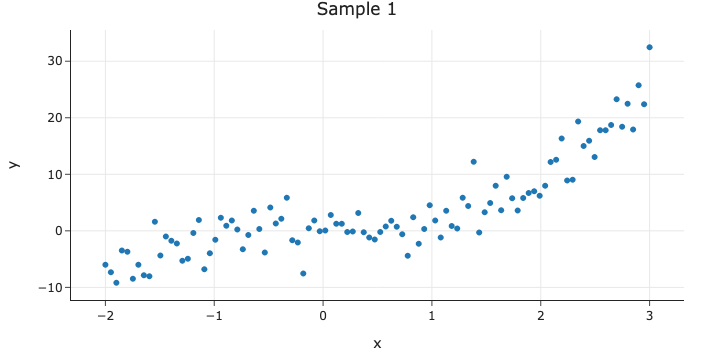

In [48]:
px.scatter(sample_1, x='x', y='y', title='Sample 1')

### Another example: Tips

We can also use $k$-fold cross-validation to determine which subset of features to use in a linear model that predicts tips by making one pipeline for each subset of features we want to evaluate.

In [49]:
# make_column_transformer is a shortcut for the ColumnTransformer class
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

As we should always do, we'll perform a train-test split on `tips` and will only use the training data for cross-validation.

In [50]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [51]:
X = tips.drop('tip', axis=1)
y = tips['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [52]:
# A dictionary that maps names to Pipeline objects.
select = FunctionTransformer(lambda x: x)
pipes = {
    'total_bill only': make_pipeline(
        make_column_transformer( (select, ['total_bill']) ),
        LinearRegression(),
    ),
    'total_bill + size': make_pipeline(
        make_column_transformer( (select, ['total_bill', 'size']) ),
        LinearRegression(),
    ),
    'total_bill + size + OHE smoker': make_pipeline(
        make_column_transformer(
            (select, ['total_bill', 'size']),
            (OneHotEncoder(drop='first'), ['smoker']),
        ),
        LinearRegression(),
    ),
    'total_bill + size + OHE all': make_pipeline(
        make_column_transformer(
            (select, ['total_bill', 'size']),
            (OneHotEncoder(drop='first'), ['smoker', 'sex', 'time', 'day']),
        ),
        LinearRegression(),
    ),
}

In [53]:
pipe_df = pd.DataFrame()

for pipe in pipes:
    errs = cross_val_score(pipes[pipe], X_train, y_train,
                           cv=5, scoring='neg_root_mean_squared_error')
    pipe_df[pipe] = -errs
    
pipe_df.index = [f'Fold {i}' for i in range(1, 6)]
pipe_df.index.name = 'Validation Fold'

In [54]:
pipe_df

,total_bill only,total_bill + size,total_bill + size + OHE smoker,total_bill + size + OHE all
Validation Fold,,,,
Fold 1,1.32,1.27,1.27,1.29
Fold 2,0.95,0.92,0.93,0.93
Fold 3,0.77,0.86,0.86,0.87
Fold 4,0.85,0.84,0.84,0.86
Fold 5,1.10,1.07,1.07,1.08


In [55]:
pipe_df.mean()

total_bill only                   1.00
total_bill + size                 0.99
total_bill + size + OHE smoker    0.99
total_bill + size + OHE all       1.01
dtype: float64

In [56]:
pipe_df.mean().idxmin()

'total_bill + size + OHE smoker'

Even though the third model has the lowest average validation RMSE, its average validation RMSE is very close to that of the other, simpler models, and as a result we'd likely use the simplest model in practice.

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>

- Suppose you have a training dataset with 1000 rows.
- You want to decide between 20 hyperparameters for a particular model.
- To do so, you perform 10-fold cross-validation.
- **How many times is the first row in the training dataset (`X.iloc[0]`) used for training a model?**


### Summary: Generalization

1. Split the data into two sets: <span style='color: blue'><b>training</b></span> and <span style='color: orange'><b>test</b></span>.

2. Use only the <span style='color: blue'><b>training</b></span> data when designing, training, and tuning the model.
    - Use <span style='color: green'><b>$k$-fold cross-validation</b></span> to choose hyperparameters and estimate the model's ability to generalize.
    - Do not ❌ look at the <span style='color: orange'><b>test</b></span> data in this step!

3. Commit to your final model and train it using the entire <span style='color: blue'><b>training</b></span> set.

4. Test the data using the <span style='color: orange'><b>test</b></span> data. If the performance (e.g. RMSE) is not acceptable, return to step 2.

5. Finally, train on **all available data** and ship the model to production! 🛳

🚨 This is the process you should **always** use! 🚨 

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>

Ask a question about the material so far!

## Decision trees 🌲

<center><img src='imgs/ml-taxonomy.svg' width=50%></center>

Decision trees can be used for both regression and classification. We'll start by using them for **classification**.

### Example: Should I get groceries?

Decision trees make classifications by answering a series of yes/no questions.

**Should I go to Trader Joe's to buy groceries today?**

<center><img src='imgs/dtree-basic.svg' width=400></center>

Internal **nodes** of trees involve questions; leaf nodes make predictions $H(x)$.

<center><img src='imgs/dtree-basic-plot.svg' width=400></center>

### Example: Predicting diabetes

In [57]:
diabetes = pd.read_csv(Path('data') / 'diabetes.csv')
display_df(diabetes, cols=9)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.63,50,1
1,1,85,66,29,0,26.6,0.35,31,0
2,8,183,64,0,0,23.3,0.67,32,1
...,...,...,...,...,...,...,...,...,...
765,5,121,72,23,112,26.2,0.24,30,0
766,1,126,60,0,0,30.1,0.35,47,1
767,1,93,70,31,0,30.4,0.32,23,0


In [58]:
# 0 means no diabetes, 1 means yes diabetes.
diabetes['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

- `'Glucose'` is measured in mg/dL (milligrams per deciliter).

- `'BMI'` is calculated as $\text{BMI} = \frac{\text{weight (kg)}}{\left[ \text{height (m)} \right]^2}$.

- Let's use `'Glucose'` and `'BMI'` to predict whether or not a patient has diabetes (`'Outcome'`).

### Exploring the dataset

First, a train-test split:

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = (
    train_test_split(diabetes[['Glucose', 'BMI']], diabetes['Outcome'], random_state=1)
)

<span style='color: orange'><b>Class 0 (orange) is "no diabetes"</b></span> and <span style='color: blue'><b>class 1 (blue) is "diabetes"</b></span>.

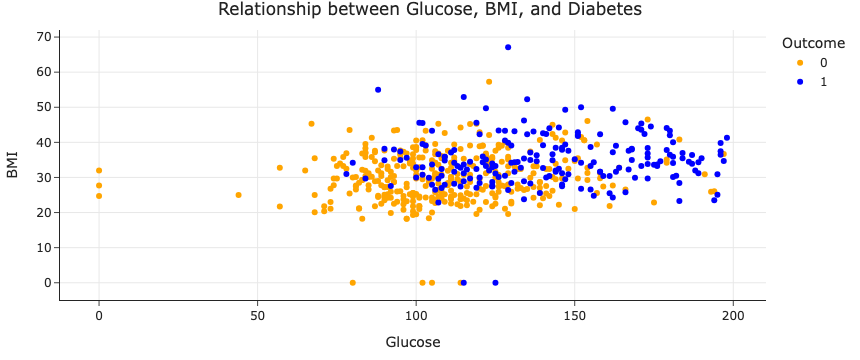

In [60]:
fig = (
    X_train.assign(Outcome=y_train.astype(str))
            .plot(kind='scatter', x='Glucose', y='BMI', color='Outcome', 
                  color_discrete_map={'0': 'orange', '1': 'blue'},
                  title='Relationship between Glucose, BMI, and Diabetes')
)
fig

### Building a decision tree

Let's build a decision tree and interpret the results.

The relevant class is `DecisionTreeClassifier`, from `sklearn.tree`.

In [61]:
from sklearn.tree import DecisionTreeClassifier

Note that we `fit` it the same way we `fit` earlier estimators.

_You may wonder what `max_depth` and `criterion` do – more on this soon!_

In [62]:
dt = DecisionTreeClassifier(max_depth=2, criterion='entropy')

In [63]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

### Visualizing decision trees

Our fit decision tree is like a "flowchart", made up of a series of questions.

As before, <span style='color: orange'><b>orange is "no diabetes"</b></span> and <span style='color: blue'><b>blue  is "diabetes"</b></span>.

In [64]:
from sklearn.tree import plot_tree

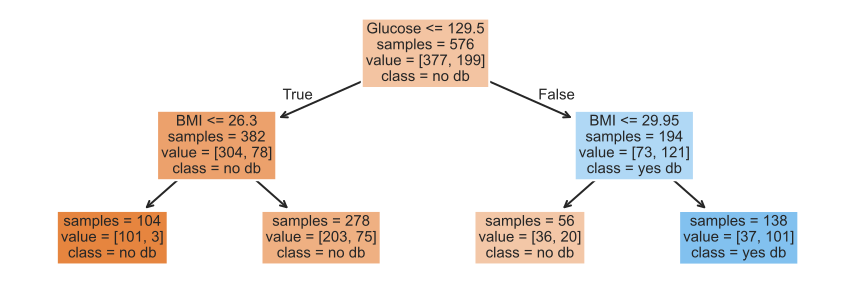

In [65]:
plt.figure(figsize=(15, 5))
plot_tree(dt, feature_names=X_train.columns, class_names=['no db', 'yes db'], 
          filled=True, fontsize=15, impurity=False);

- To **classify a new data point**, we start at the top and answer the first question (i.e. "Glucose <= 129.5").

- If the answer is "**Yes**", we move to the **left** branch, otherwise we move to the right branch.

- We repeat this process until we end up at a leaf node, at which point we predict the most common class in that node.
    - Note that each node has a `value` attribute, which describes the number of **training** individuals of each class that fell in that node.

In [66]:
# Note that the left node at depth 2 has a `value` of [304, 78].
y_train[X_train.query('Glucose <= 129.5').index].value_counts()

Outcome
0    304
1     78
Name: count, dtype: int64

### Evaluating classifiers

The most common evaluation metric in classification is **accuracy**:

$$\text{accuracy} = \frac{\text{\# data points classified correctly}}{\text{\# data points}}$$

In [68]:
(dt.predict(X_train) == y_train).mean()

np.float64(0.765625)

The `score` method of a classifier computes accuracy by default (just like the `score` method of a regressor computes $R^2$ by default). We want our classifiers to have **high accuracy**.

In [69]:
# Training accuracy – same number as above
dt.score(X_train, y_train)

0.765625

In [70]:
# Testing accuracy
dt.score(X_test, y_test)

0.7760416666666666

### Reflection

- Decision trees are easily interpretable: it is clear _how_ they make their predictions.

- They work with categorical data without needing to use one hot encoding.

- They also can be used in multi-class classification problems, e.g. when there are more than 2 possible outcomes.

- The _decision boundary_ of a decision tree can be arbitrarily complicated.

- **How are decision trees trained?**

### How are decision trees trained?

Pseudocode:

```python
def make_tree(X, y):
    if all points in y have the same label C:
        return Leaf(C)
    f = best splitting feature # e.g. Glucose or BMI
    v = best splitting value   # e.g. 129.5
    
    X_left, y_left   = X, y where (X[f] <= v)
    X_right, y_right = X, y where (X[f] > v)
    
    left  = make_tree(X_left, y_left)
    right = make_tree(X_right, y_right)
    
    return Node(f, v, left, right)
    
make_tree(X_train, y_train)
```

### How do we measure the quality of a split?

Our pseudocode for training a decision tree relies on finding the best way to "split" a node – that is, **the best question to ask** to help us narrow down which class to predict.

**Intuition**: Suppose the distribution within a node looks like this (colors represent classes):

<center>🟠🟠🟠🟠🟠🟠🔵🔵🔵🔵🔵🔵🔵</center>

Split A:
- "Yes": 🟠🟠🟠🔵🔵🔵
- "No": 🟠🟠🟠🔵🔵🔵🔵

Split B:
- "Yes": 🔵🔵🔵🔵🔵🔵
- "No": 🔵🟠🟠🟠🟠🟠🟠

**Which split is "better"?**

Split B, because there is "less uncertainty" in the resulting nodes in Split B than there is in Split A. Let's try and quantify this!

### Entropy

- For each class $C$ within a node, define $p_C$ as the proportion of points with that class.
    - For example, the two classes may be "yes diabetes" and "no diabetes".

- The **surprise** of drawing a point from the node at random and having it be class $C$ is:

$$
- \log_2 p_C
$$

- The **entropy** of a node is the average surprise over all classes:

\begin{align}
\text{entropy} &= - \sum_C p_C \log_2 p_C
\end{align}

- The entropy of 🟠🟠🟠🟠🟠🟠🟠🟠 is $ -1 \log_2(1) = 0 $.

- The entropy of 🟠🟠🟠🟠🔵🔵🔵🔵 is $ -0.5 \log_2(0.5) - 0.5 \log_2(0.5) = 1$.

- The entropy of 🟠🔵🟢🟡🟣 is $ - \log_2 \frac{1}{5} = \log_2(5) $
    - In general, if a node has $n$ points, all with different labels, the entropy of the node is $ \log_2(n) $.

### Example entropy calculation

Suppose we have:

<center>🟠🟠🟠🟠🟠🟠🟠🟠🟠🟠🟠🟠🔵🔵🔵🔵🔵🔵</center>

Split A:
- "Yes": 🟠🟠🟠🟠🟠🟠🔵
- "No": 🟠🟠🟠🟠🟠🟠🔵🔵🔵🔵🔵

Split B:
- "Yes": 🟠🟠🟠🟠🟠🟠🔵🔵🔵
- "No": 🟠🟠🟠🟠🟠🟠🔵🔵🔵

We choose the split that has the lowest **weighted entropy**, that is:

$$\text{entropy of split} = \frac{\# \text{Yes}}{\# \text{Yes} + \# \text{No}} \cdot \text{entropy(Yes)} + \frac{\# \text{No}}{\# \text{Yes} + \# \text{No}} \cdot \text{entropy(No)}$$

In [71]:
def entropy(node):
    props = pd.Series(list(node)).value_counts(normalize=True)
    return -sum(props * np.log2(props))

In [72]:
def weighted_entropy(yes_node, no_node):
    yes_entropy = entropy(yes_node)
    no_entropy = entropy(no_node)
    yes_weight = len(yes_node) / (len(yes_node) + len(no_node))
    return yes_weight * yes_entropy + (1 - yes_weight) * no_entropy

In [73]:
# Split A:
weighted_entropy("🟠🟠🟠🟠🟠🟠🔵", "🟠🟠🟠🟠🟠🟠🔵🔵🔵🔵🔵")

0.8375578764623786

In [74]:
# Split B:
weighted_entropy("🟠🟠🟠🟠🟠🟠🔵🔵🔵", "🟠🟠🟠🟠🟠🟠🔵🔵🔵")

0.9182958340544896

Split A has the lower weighted entropy, so we'll use it.

### Understanding entropy

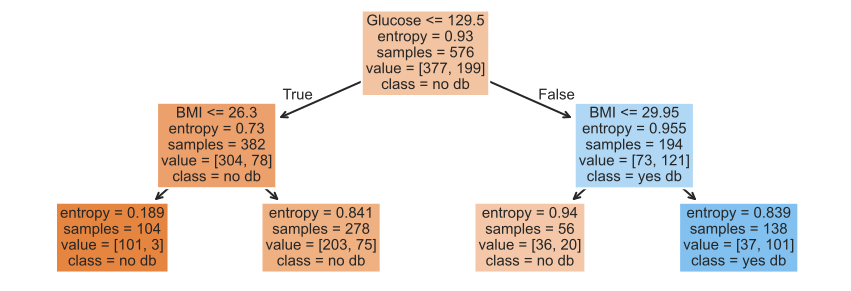

In [75]:
plt.figure(figsize=(15, 5))
plot_tree(dt, feature_names=X_train.columns, class_names=['no db', 'yes db'], 
          filled=True, fontsize=15, impurity=True);

We can recreate the entropy calculations above! Note that the default `DecisionTreeClassifier` uncertaintly metric _isn't_ entropy; it used entropy because we set `criterion='entropy'` when defining `dt`. (The default metric, [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%20measures%20how%20often,into%20a%20single%20target%20category.), is perfectly fine too!)

In [76]:
# The first node at depth 2 has an entropy of 0.73,
# both told to us above and verified here!
entropy([0] * 304 + [1] * 78)

0.7302263747422792

### Tree depth

Decision trees are trained by **recursively** picking the best split until:

- all "leaf nodes" only contain training examples from a single class (good), or
- it is impossible to split leaf nodes any further (not good).

By default, there is no "maximum depth" for a decision tree. As such, without restriction, decision trees tend to be very deep.

In [77]:
dt_no_max = DecisionTreeClassifier()
dt_no_max.fit(X_train, y_train)

DecisionTreeClassifier()

A decision tree fit on our training data has a depth of around 20! (It is so deep that `tree.plot_tree` errors when trying to plot it.)

In [78]:
dt_no_max.tree_.max_depth

22

At first, this tree seems "better" than our tree of depth 2, since its training accuracy is much much higher:

In [79]:
dt_no_max.score(X_train, y_train)

0.9913194444444444

In [80]:
# Depth 2 tree.
dt.score(X_train, y_train)

0.765625

But recall, we truly care about **test set performance**, and this decision tree has **worse accuracy on the test set than our depth 2 tree**.

In [81]:
dt_no_max.score(X_test, y_test)

0.71875

In [82]:
# Depth 2 tree.
dt.score(X_test, y_test)

0.7760416666666666

### Decision trees and overfitting

- Decision trees have a tendency to overfit. **Why is that?**

- Unlike linear classification techniques (like logistic regression or SVMs), **decision trees are non-linear**.
    - They are also "non-parametric" – there are no $w^*$s to learn.

- While being trained, decision trees ask enough questions to effectively **memorize** the correct response values in the training set. However, the relationships they learn are often overfit to the noise in the training set, and don't generalize well.

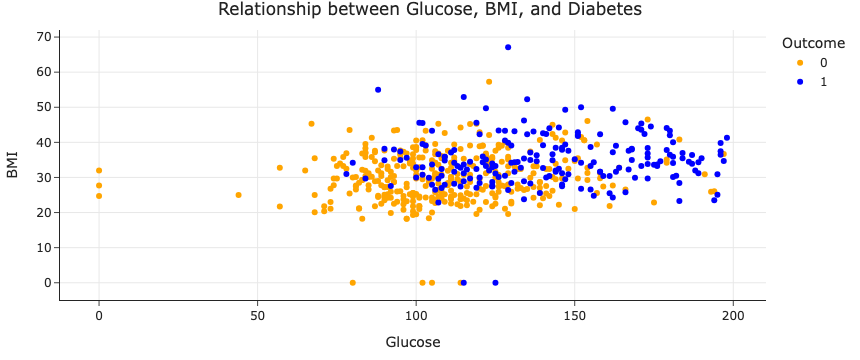

In [83]:
fig

- A decision tree whose depth is not restricted will achieve 100% accuracy on any training set, as long as there are no "overlapping values" in the training set.
    - Two values overlap when they have the same features $x$ but different response values $y$ (e.g. if two patients have the same glucose levels and BMI, but one has diabetes and one doesn't).

- **One solution**: Make the decision tree "less complex" by limiting the maximum depth.

Since `sklearn.tree`'s `plot_tree` can't visualize extremely large decision trees, let's create and visualize some smaller decision trees.

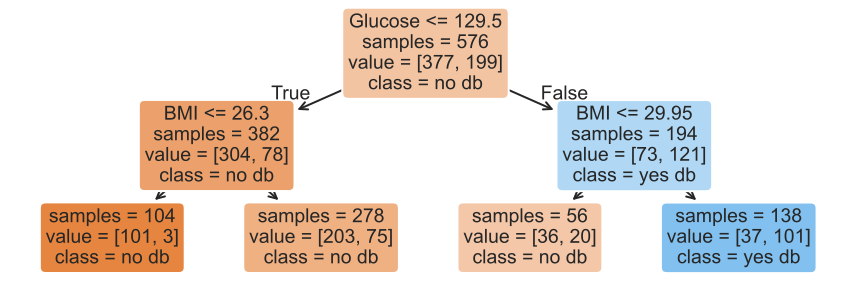

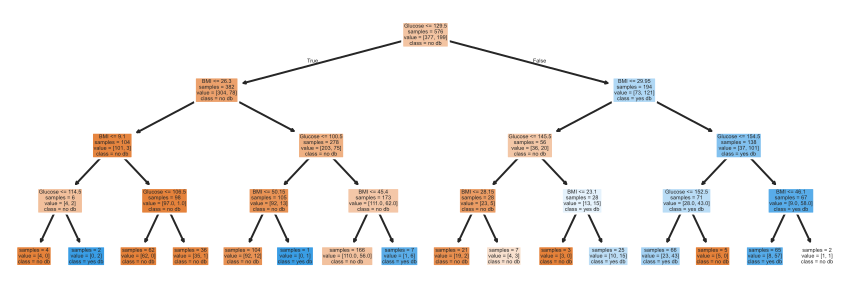

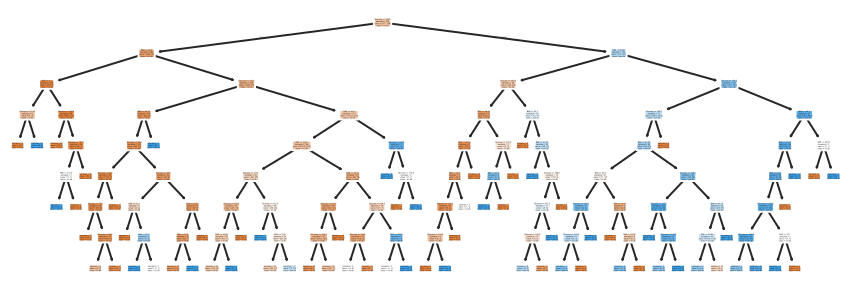

In [84]:
trees = {}
for d in [2, 4, 8]:
    trees[d] = DecisionTreeClassifier(max_depth=d, random_state=1)
    trees[d].fit(X_train, y_train)
    
    plt.figure(figsize=(15, 5), dpi=100)
    plot_tree(trees[d], feature_names=X_train.columns, class_names=['no db', 'yes db'], 
               filled=True, rounded=True, impurity=False)
    
    plt.show()

As tree depth increases, complexity increases, and our trees are more prone to overfitting. This means model bias decreases, but model variance increases. 

**Question**: What is the "right" maximum depth to choose?

### Hyperparameters for decision trees

- `max_depth` is a hyperparameter for `DecisionTreeClassifier`.

- There are many more hyperparameters we can tweak; look at [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for examples.
    - `min_samples_split`: The minimum number of samples required to split an internal node.
    - `criterion`: The function to measure the quality of a split (`'gini'` or `'entropy'`).

- To ensure that our model generalizes well to unseen data, we need an efficient technique for trying different combinations of hyperparameters!

- We'll see that technique next time: `GridSearchCV`.

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>


Suppose we fit decision trees of varying depths to predict 'y' using 'x1' and 'x2'. The entire training set is shown in the table below.

<center><img src='https://practice.dsc80.com/assets/images/fa23-final/dsc_80_final_q10.png' width=15%></center>

What is:

1. The entropy of a node containing all the training points.
1. The lowest possible entropy of a node in a fitted tree with depth 1 (two leaf nodes).
1. The lowest possible entropy of a node in a fitted tree with depth 2 (four leaf nodes).

## Summary, next time

### Summary

- A hyperparameter is a configuration that we choose before training a model; an important task in machine learning is selecting "good" hyperparameters.
- To choose hyperparameters, we use $k$-fold cross-validation. **This technique is standard, and you are expected to use it in the Final Project!**
    - See [Summary: Generalization](#Summary:-Generalization) for more.
- Decision trees can be used for both regression and classification; we've used them for classification.
    - Decision trees are trained recursively. Each node corresponds to a "yes" or "no" question.
    - To decide which "yes" or "no" question to ask, we choose the question with the lowest weighted entropy.

### Next time

- An efficient technique for trying different combinations of hyperparameters.
    - In other words, performing $k$-fold cross-validation _without_ a `for`-loop.
- Techniques for evaluating classifiers beyond accuracy.
    - You'll need this for the Final Project!